# Individual Season PCA Comparison (2020-2025)

## Objective
Test PCA stability and predictive power by fitting **independent models for each season** across **ALL 7 categories**.

**Key Questions:**
1. Are PC1 loadings consistent across seasons? (stability test)
2. Does PCA score correlate with league position? (validation test)
3. Does PCA outperform equal-weight composite? (comparison test)
4. Which categories are stable enough for 10-year baseline?

**Data:**
- 5 seasons (2020-2021 through 2024-2025)
- 7 categories × 5 seasons = **35 independent PCA models**
- Final league standings for correlation analysis

---

In [70]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from pca_analysis_utils import *

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports complete")

✅ Imports complete


In [71]:
# Connect to analytics database
db_path = '../data/premierleague_analytics.duckdb'
conn = duckdb.connect(db_path, read_only=True)

print(f"✅ Connected to: {db_path}")

✅ Connected to: ../data/premierleague_analytics.duckdb


## 1. Load 5 Seasons of Squad Data (2020-2025)

In [72]:
# Load squad stats for 5 recent seasons
seasons = ['2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']

season_data = {}
for season in seasons:
    query = f"""
    SELECT *
    FROM analytics_squads
    WHERE season = '{season}'
    ORDER BY squad_name
    """
    season_data[season] = conn.execute(query).df()
    print(f"📊 {season}: {len(season_data[season])} squads")

print(f"\n✅ Loaded {len(seasons)} seasons")

📊 2020-2021: 20 squads
📊 2021-2022: 20 squads
📊 2022-2023: 20 squads
📊 2023-2024: 20 squads
📊 2024-2025: 20 squads

✅ Loaded 5 seasons


In [73]:
# Define negative metrics
NEGATIVE_METRICS = {'penalty_kicks_attempted_against', 'miscontrols', 'goals_against_per_90', 'yellow_cards', 'challenges_lost', 'own_goals_for', 'penalty_goals_against', 'aerial_duels_lost', 'goals_against', 'take_ons_tackled_rate', 'fouls_committed', 'offsides_pass_types', 'blocked_passes', 'corner_kick_goals_against', 'dispossessed', 'crosses_faced', 'penalty_kicks_against', 'free_kick_goals_against', 'second_yellow_cards', 'take_ons_tackled', 'errors', 'offsides', 'red_cards', 'average_shot_distance', 'shots_on_target_against', 'own_goals', 'penalty_kicks_conceded'}

print(f"📌 Negative metrics to invert: {len(NEGATIVE_METRICS)}")

📌 Negative metrics to invert: 27


In [74]:
# Load category definitions
with open('full_categories.json', 'r') as f:
    FULL_CATEGORIES = json.load(f)

print(f"📊 Categories loaded: {len(FULL_CATEGORIES)}")
for cat_name, cat_info in FULL_CATEGORIES.items():
    print(f"   {cat_name:20s}: {len(cat_info['metrics'])} metrics")

📊 Categories loaded: 7
   attacking_output    : 33 metrics
   creativity          : 25 metrics
   passing             : 28 metrics
   ball_progression    : 18 metrics
   defending           : 38 metrics
   physical_duels      : 15 metrics
   possession          : 12 metrics


## 2. Fit Independent PCA for Each Season × Category

**35 models total:** 7 categories × 5 seasons

In [75]:
# Fit PCA for each category × season combination
seasonal_results = {cat: {} for cat in FULL_CATEGORIES.keys()}

print("="*80)
print("FITTING SEASONAL PCA MODELS (7 categories × 5 seasons = 35 models)")
print("="*80)

for cat_name in FULL_CATEGORIES.keys():
    print(f"\n🎯 {cat_name}")
    print("   " + "─"*70)

    for season in seasons:
        df_season = season_data[season]

        # Prepare data
        cat_df, metrics, _ = prepare_category_data(df_season, cat_name, NEGATIVE_METRICS)
        X = cat_df[metrics].values

        # Fit PCA
        results = fit_pca_model(X, variance_threshold=0.80)

        # Get top loadings
        top_loadings = get_top_loadings(results['pca'], metrics, n_top=5)

        # Calculate scores
        scores, weights = calculate_weighted_scores(
            results['X_pca'],
            results['explained_variance_ratio'],
            results['n_components']
        )

        # Store comprehensive results
        seasonal_results[cat_name][season] = {
            'pca': results['pca'],
            'scaler': results['scaler'],
            'n_components': results['n_components'],
            'pc1_variance': results['pc1_variance'],
            'cumulative_variance': results['cumulative_variance'],
            'explained_variance_ratio': results['explained_variance_ratio'],
            'top_loadings': top_loadings,
            'top_metric': top_loadings.index[0],
            'scores': scores,
            'squad_names': cat_df['squad_name'].values,
            'metrics': metrics
        }

        print(f"   {season}: PC1={results['pc1_variance']:.1%}, "
              f"Components={results['n_components']}, "
              f"Top={top_loadings.index[0]}")

print("\n" + "="*80)
print(f"✅ ALL 35 MODELS FITTED SUCCESSFULLY")
print("="*80)

FITTING SEASONAL PCA MODELS (7 categories × 5 seasons = 35 models)

🎯 attacking_output
   ──────────────────────────────────────────────────────────────────────
   2020-2021: PC1=70.9%, Components=2, Top=goals
   2021-2022: PC1=75.1%, Components=2, Top=goals
   2022-2023: PC1=69.3%, Components=2, Top=goals_plus_assists
   2023-2024: PC1=69.8%, Components=2, Top=goals_per_90
   2024-2025: PC1=69.2%, Components=2, Top=goals_per_90

🎯 creativity
   ──────────────────────────────────────────────────────────────────────
   2020-2021: PC1=52.3%, Components=4, Top=shot_creating_actions
   2021-2022: PC1=58.3%, Components=4, Top=shot_creating_actions
   2022-2023: PC1=51.6%, Components=5, Top=shot_creating_actions
   2023-2024: PC1=49.2%, Components=5, Top=shot_creating_actions
   2024-2025: PC1=49.9%, Components=5, Top=shot_creating_actions_per_90

🎯 passing
   ──────────────────────────────────────────────────────────────────────
   2020-2021: PC1=62.5%, Components=3, Top=total_pass_distance

## 3. PC1 Variance Grid - All Categories × Seasons

In [76]:
# Create grid showing PC1 variance for all combinations
grid_data = []
for cat_name in FULL_CATEGORIES.keys():
    row = [seasonal_results[cat_name][s]['pc1_variance'] for s in seasons]
    grid_data.append(row)

df_grid = pd.DataFrame(grid_data, index=list(FULL_CATEGORIES.keys()), columns=seasons)

# Display with styling
display(df_grid.style.background_gradient(cmap='RdYlGn', vmin=0.2, vmax=0.7).format("{:.1%}"))

print("\n💡 Interpretation:")
print("   - Green cells: High PC1 variance (metrics highly correlated)")
print("   - Red cells: Low PC1 variance (metrics measure different aspects)")
print("   - Consistent columns: Category has stable variance across years")

,2020-2021,2021-2022,2022-2023,2023-2024,2024-2025
attacking_output,70.9%,75.1%,69.3%,69.8%,69.2%
creativity,52.3%,58.3%,51.6%,49.2%,49.9%
passing,62.5%,63.4%,60.3%,63.1%,56.2%
ball_progression,51.5%,50.5%,48.2%,50.5%,48.0%
defending,30.4%,43.7%,35.5%,33.1%,32.3%
physical_duels,27.7%,25.3%,25.5%,29.1%,26.4%
possession,65.7%,67.5%,64.6%,63.4%,62.1%



💡 Interpretation:
   - Green cells: High PC1 variance (metrics highly correlated)
   - Red cells: Low PC1 variance (metrics measure different aspects)
   - Consistent columns: Category has stable variance across years


## 4. Loading Stability Analysis

**Method:** Compare top 5 PC1 loadings across 5 seasons for each category.

### 4.1 attacking_output

In [77]:
# Stability analysis for attacking_output
cat_name = 'attacking_output'

# Get top loadings across seasons
all_top_loadings = {s: seasonal_results[cat_name][s]['top_loadings'].index.tolist() for s in seasons}

# Analyze stability
stability = analyze_stability(all_top_loadings, seasons, n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"\nTop 5 metric frequencies across {len(seasons)} seasons:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(seasons) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(seasons)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of seasons):")
if stability['stable_metrics']:
    print(f"   {', '.join(stability['stable_metrics'])}")
else:
    print("   None - high variance in loadings")

print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability
seasonal_results[cat_name]['stability'] = stability

attacking_output - Stability Analysis

Top 5 metric frequencies across 5 seasons:
  goals                                         5/5 ████████████████████ 100%
  goals_per_90                                  5/5 ████████████████████ 100%
  goals_plus_assists                            5/5 ████████████████████ 100%
  goals_plus_assists_per_90                     4/5 ████████████████ 80%
  non_penalty_goals                             2/5 ████████ 40%
  non_penalty_goals_per_90                      2/5 ████████ 40%
  goals_plus_assists_minus_pks_per_90           1/5 ████ 20%
  non_penalty_expected_goals                    1/5 ████ 20%

✅ Stable metrics (appear in 80%+ of seasons):
   goals, goals_per_90, goals_plus_assists, goals_plus_assists_per_90

Stability score: 80.0%
Overall: ✅ STABLE


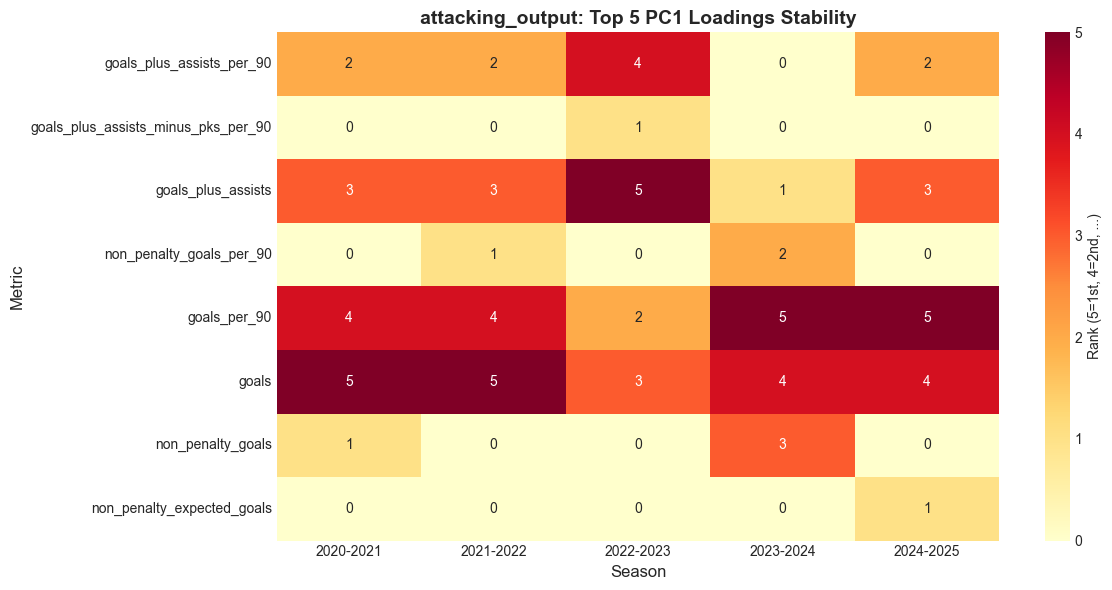

In [78]:
# Heatmap for attacking_output
fig = plot_loading_stability_heatmap('attacking_output', all_top_loadings, seasons)
plt.show()

### 4.2 creativity

In [79]:
# Stability analysis for creativity
cat_name = 'creativity'

# Get top loadings across seasons
all_top_loadings = {s: seasonal_results[cat_name][s]['top_loadings'].index.tolist() for s in seasons}

# Analyze stability
stability = analyze_stability(all_top_loadings, seasons, n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"\nTop 5 metric frequencies across {len(seasons)} seasons:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(seasons) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(seasons)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of seasons):")
if stability['stable_metrics']:
    print(f"   {', '.join(stability['stable_metrics'])}")
else:
    print("   None - high variance in loadings")

print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability
seasonal_results[cat_name]['stability'] = stability

creativity - Stability Analysis

Top 5 metric frequencies across 5 seasons:
  shot_creating_actions                         5/5 ████████████████████ 100%
  shot_creating_actions_per_90                  5/5 ████████████████████ 100%
  sca_pass_live                                 5/5 ████████████████████ 100%
  key_passes                                    5/5 ████████████████████ 100%
  passes_penalty_area                           3/5 ████████████ 60%
  sca_shot                                      1/5 ████ 20%
  passes_final_third                            1/5 ████ 20%

✅ Stable metrics (appear in 80%+ of seasons):
   shot_creating_actions, shot_creating_actions_per_90, sca_pass_live, key_passes

Stability score: 80.0%
Overall: ✅ STABLE


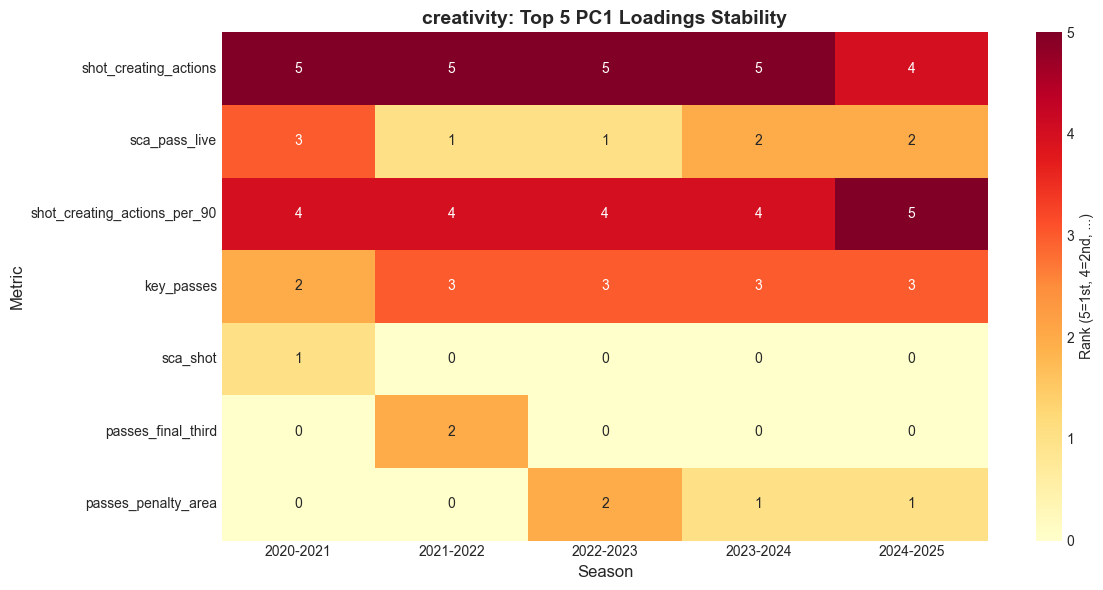

In [80]:
# Heatmap for creativity
fig = plot_loading_stability_heatmap('creativity', all_top_loadings, seasons)
plt.show()

### 4.3 passing

In [81]:
# Stability analysis for passing
cat_name = 'passing'

# Get top loadings across seasons
all_top_loadings = {s: seasonal_results[cat_name][s]['top_loadings'].index.tolist() for s in seasons}

# Analyze stability
stability = analyze_stability(all_top_loadings, seasons, n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"\nTop 5 metric frequencies across {len(seasons)} seasons:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(seasons) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(seasons)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of seasons):")
if stability['stable_metrics']:
    print(f"   {', '.join(stability['stable_metrics'])}")
else:
    print("   None - high variance in loadings")

print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability
seasonal_results[cat_name]['stability'] = stability

passing - Stability Analysis

Top 5 metric frequencies across 5 seasons:
  passes_completed                              5/5 ████████████████████ 100%
  completed_passes_types                        5/5 ████████████████████ 100%
  live_ball_passes                              4/5 ████████████████ 80%
  passes_attempted                              4/5 ████████████████ 80%
  total_pass_distance                           3/5 ████████████ 60%
  medium_passes_completed                       2/5 ████████ 40%
  medium_passes_attempted                       1/5 ████ 20%
  pass_completion_rate                          1/5 ████ 20%

✅ Stable metrics (appear in 80%+ of seasons):
   passes_completed, completed_passes_types, live_ball_passes, passes_attempted

Stability score: 80.0%
Overall: ✅ STABLE


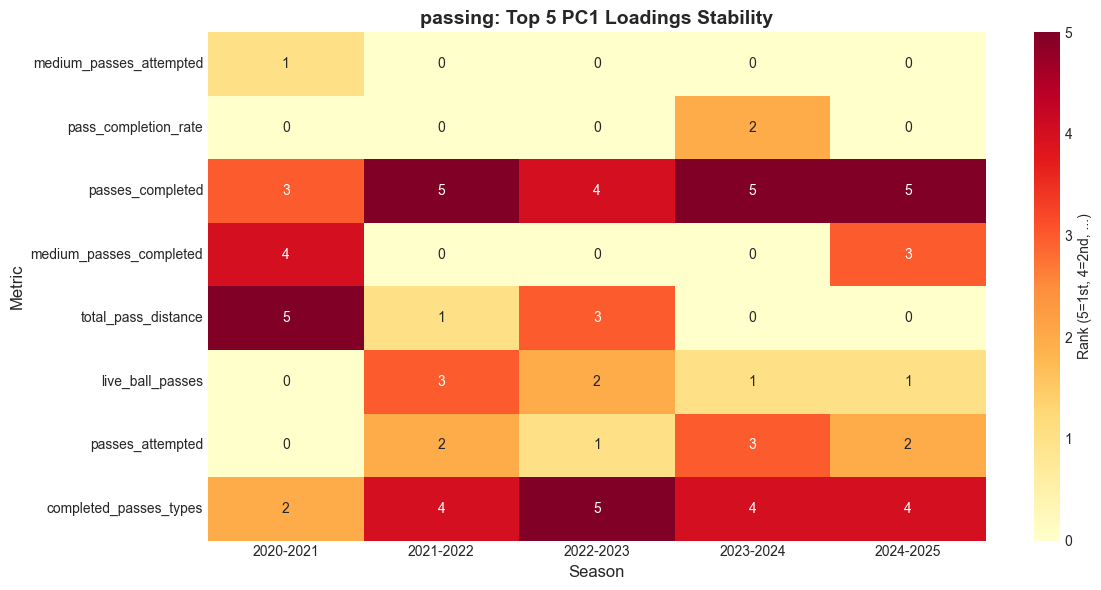

In [82]:
# Heatmap for passing
fig = plot_loading_stability_heatmap('passing', all_top_loadings, seasons)
plt.show()

### 4.4 ball_progression

In [83]:
# Stability analysis for ball_progression
cat_name = 'ball_progression'

# Get top loadings across seasons
all_top_loadings = {s: seasonal_results[cat_name][s]['top_loadings'].index.tolist() for s in seasons}

# Analyze stability
stability = analyze_stability(all_top_loadings, seasons, n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"\nTop 5 metric frequencies across {len(seasons)} seasons:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(seasons) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(seasons)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of seasons):")
if stability['stable_metrics']:
    print(f"   {', '.join(stability['stable_metrics'])}")
else:
    print("   None - high variance in loadings")

print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability
seasonal_results[cat_name]['stability'] = stability

ball_progression - Stability Analysis

Top 5 metric frequencies across 5 seasons:
  carry_distance                                5/5 ████████████████████ 100%
  progressive_carries                           5/5 ████████████████████ 100%
  progressive_carry_distance                    5/5 ████████████████████ 100%
  carries_final_third                           4/5 ████████████████ 80%
  carries                                       4/5 ████████████████ 80%
  passes_received                               2/5 ████████ 40%

✅ Stable metrics (appear in 80%+ of seasons):
   carries_final_third, carry_distance, progressive_carries, carries, progressive_carry_distance

Stability score: 100.0%
Overall: ✅ STABLE


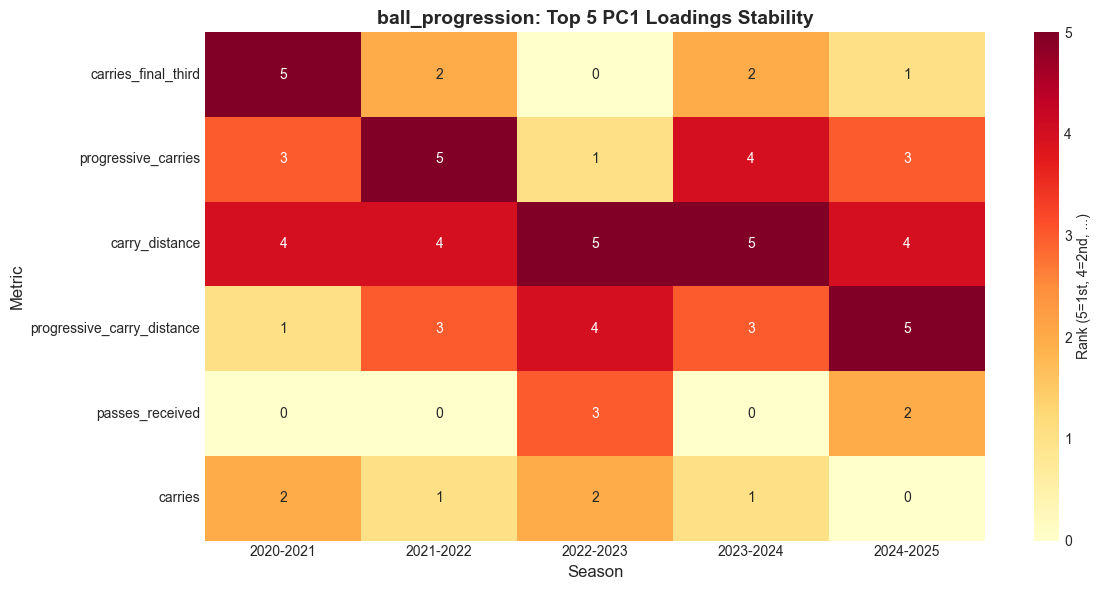

In [84]:
# Heatmap for ball_progression
fig = plot_loading_stability_heatmap('ball_progression', all_top_loadings, seasons)
plt.show()

### 4.5 defending

In [85]:
# Stability analysis for defending
cat_name = 'defending'

# Get top loadings across seasons
all_top_loadings = {s: seasonal_results[cat_name][s]['top_loadings'].index.tolist() for s in seasons}

# Analyze stability
stability = analyze_stability(all_top_loadings, seasons, n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"\nTop 5 metric frequencies across {len(seasons)} seasons:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(seasons) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(seasons)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of seasons):")
if stability['stable_metrics']:
    print(f"   {', '.join(stability['stable_metrics'])}")
else:
    print("   None - high variance in loadings")

print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability
seasonal_results[cat_name]['stability'] = stability

defending - Stability Analysis

Top 5 metric frequencies across 5 seasons:
  goals_against_per_90                          5/5 ████████████████████ 100%
  goals_against                                 4/5 ████████████████ 80%
  tackles_plus_interceptions                    2/5 ████████ 40%
  shots_on_target_against                       2/5 ████████ 40%
  clean_sheet_percentage                        2/5 ████████ 40%
  clean_sheets                                  2/5 ████████ 40%
  post_shot_expected_goals                      2/5 ████████ 40%
  blocks                                        2/5 ████████ 40%
  tackles_def_third                             1/5 ████ 20%
  challenge_tackles                             1/5 ████ 20%

✅ Stable metrics (appear in 80%+ of seasons):
   goals_against, goals_against_per_90

Stability score: 40.0%
Overall: ⚠️  UNSTABLE


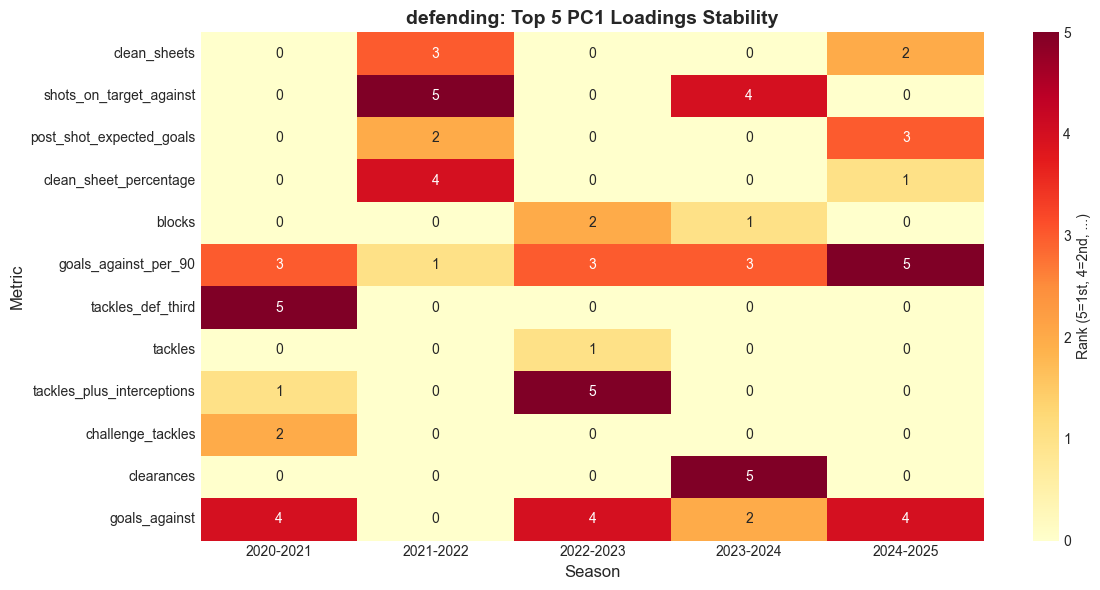

In [86]:
# Heatmap for defending
fig = plot_loading_stability_heatmap('defending', all_top_loadings, seasons)
plt.show()

### 4.6 physical_duels

In [87]:
# Stability analysis for physical_duels
cat_name = 'physical_duels'

# Get top loadings across seasons
all_top_loadings = {s: seasonal_results[cat_name][s]['top_loadings'].index.tolist() for s in seasons}

# Analyze stability
stability = analyze_stability(all_top_loadings, seasons, n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"\nTop 5 metric frequencies across {len(seasons)} seasons:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(seasons) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(seasons)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of seasons):")
if stability['stable_metrics']:
    print(f"   {', '.join(stability['stable_metrics'])}")
else:
    print("   None - high variance in loadings")

print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability
seasonal_results[cat_name]['stability'] = stability

physical_duels - Stability Analysis

Top 5 metric frequencies across 5 seasons:
  crosses_faced                                 4/5 ████████████████ 80%
  aerial_duels_lost                             4/5 ████████████████ 80%
  second_yellow_cards                           3/5 ████████████ 60%
  defensive_actions_outside_penalty_area_per_90 3/5 ████████████ 60%
  yellow_cards                                  2/5 ████████ 40%
  aerial_duels_won                              2/5 ████████ 40%
  defensive_actions_outside_penalty_area        2/5 ████████ 40%
  ball_recoveries                               1/5 ████ 20%
  crosses_stopped                               1/5 ████ 20%
  red_cards                                     1/5 ████ 20%

✅ Stable metrics (appear in 80%+ of seasons):
   crosses_faced, aerial_duels_lost

Stability score: 40.0%
Overall: ⚠️  UNSTABLE


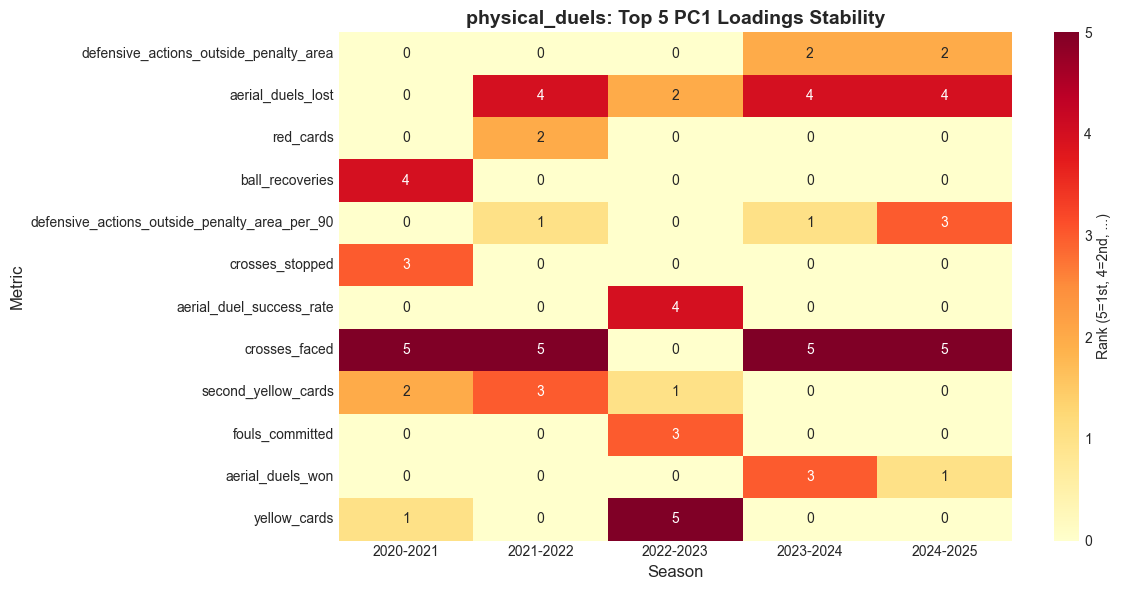

In [88]:
# Heatmap for physical_duels
fig = plot_loading_stability_heatmap('physical_duels', all_top_loadings, seasons)
plt.show()

### 4.7 possession

In [89]:
# Stability analysis for possession
cat_name = 'possession'

# Get top loadings across seasons
all_top_loadings = {s: seasonal_results[cat_name][s]['top_loadings'].index.tolist() for s in seasons}

# Analyze stability
stability = analyze_stability(all_top_loadings, seasons, n_top=5)

print(f"{cat_name} - Stability Analysis")
print("="*70)
print(f"\nTop 5 metric frequencies across {len(seasons)} seasons:")
for metric, count in stability['metric_frequencies'][:10]:
    pct = count / len(seasons) * 100
    bar = '█' * int(pct / 5)
    print(f"  {metric:45s} {count}/{len(seasons)} {bar} {pct:.0f}%")

print(f"\n✅ Stable metrics (appear in 80%+ of seasons):")
if stability['stable_metrics']:
    print(f"   {', '.join(stability['stable_metrics'])}")
else:
    print("   None - high variance in loadings")

print(f"\nStability score: {stability['stability_score']:.1%}")
print(f"Overall: {'✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'}")

# Store stability
seasonal_results[cat_name]['stability'] = stability

possession - Stability Analysis

Top 5 metric frequencies across 5 seasons:
  touches                                       5/5 ████████████████████ 100%
  touches_live_ball                             5/5 ████████████████████ 100%
  touches_mid_third                             5/5 ████████████████████ 100%
  touches_att_third                             4/5 ████████████████ 80%
  goal_kick_launch_percentage                   2/5 ████████ 40%
  touches_att_penalty                           2/5 ████████ 40%
  launch_percentage                             1/5 ████ 20%
  goal_kicks_attempted                          1/5 ████ 20%

✅ Stable metrics (appear in 80%+ of seasons):
   touches, touches_live_ball, touches_mid_third, touches_att_third

Stability score: 80.0%
Overall: ✅ STABLE


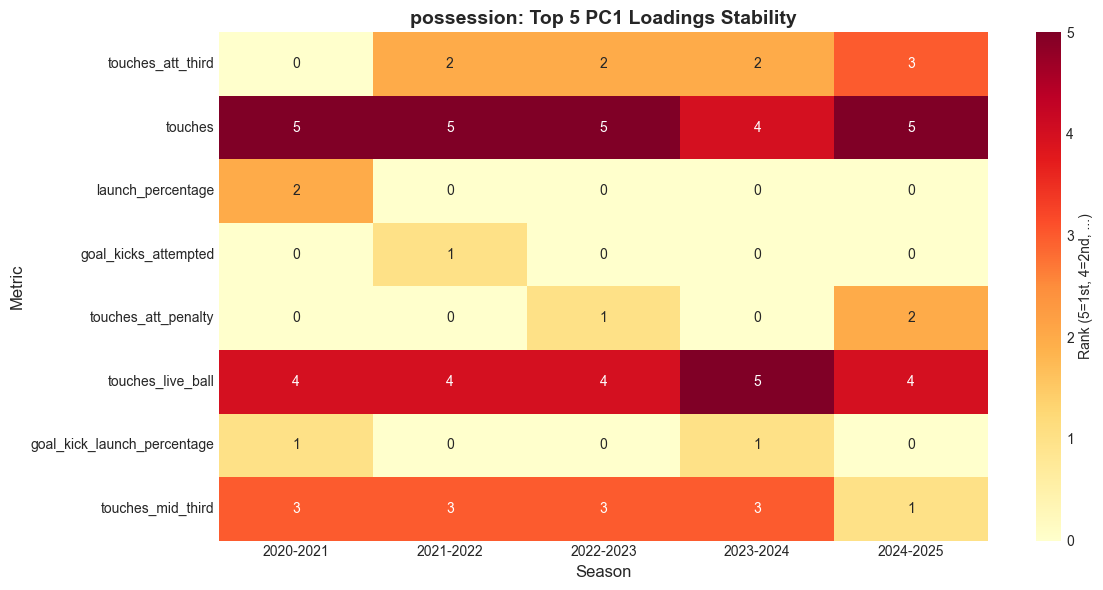

In [90]:
# Heatmap for possession
fig = plot_loading_stability_heatmap('possession', all_top_loadings, seasons)
plt.show()

## 5. PC1 Variance Trends Over Time

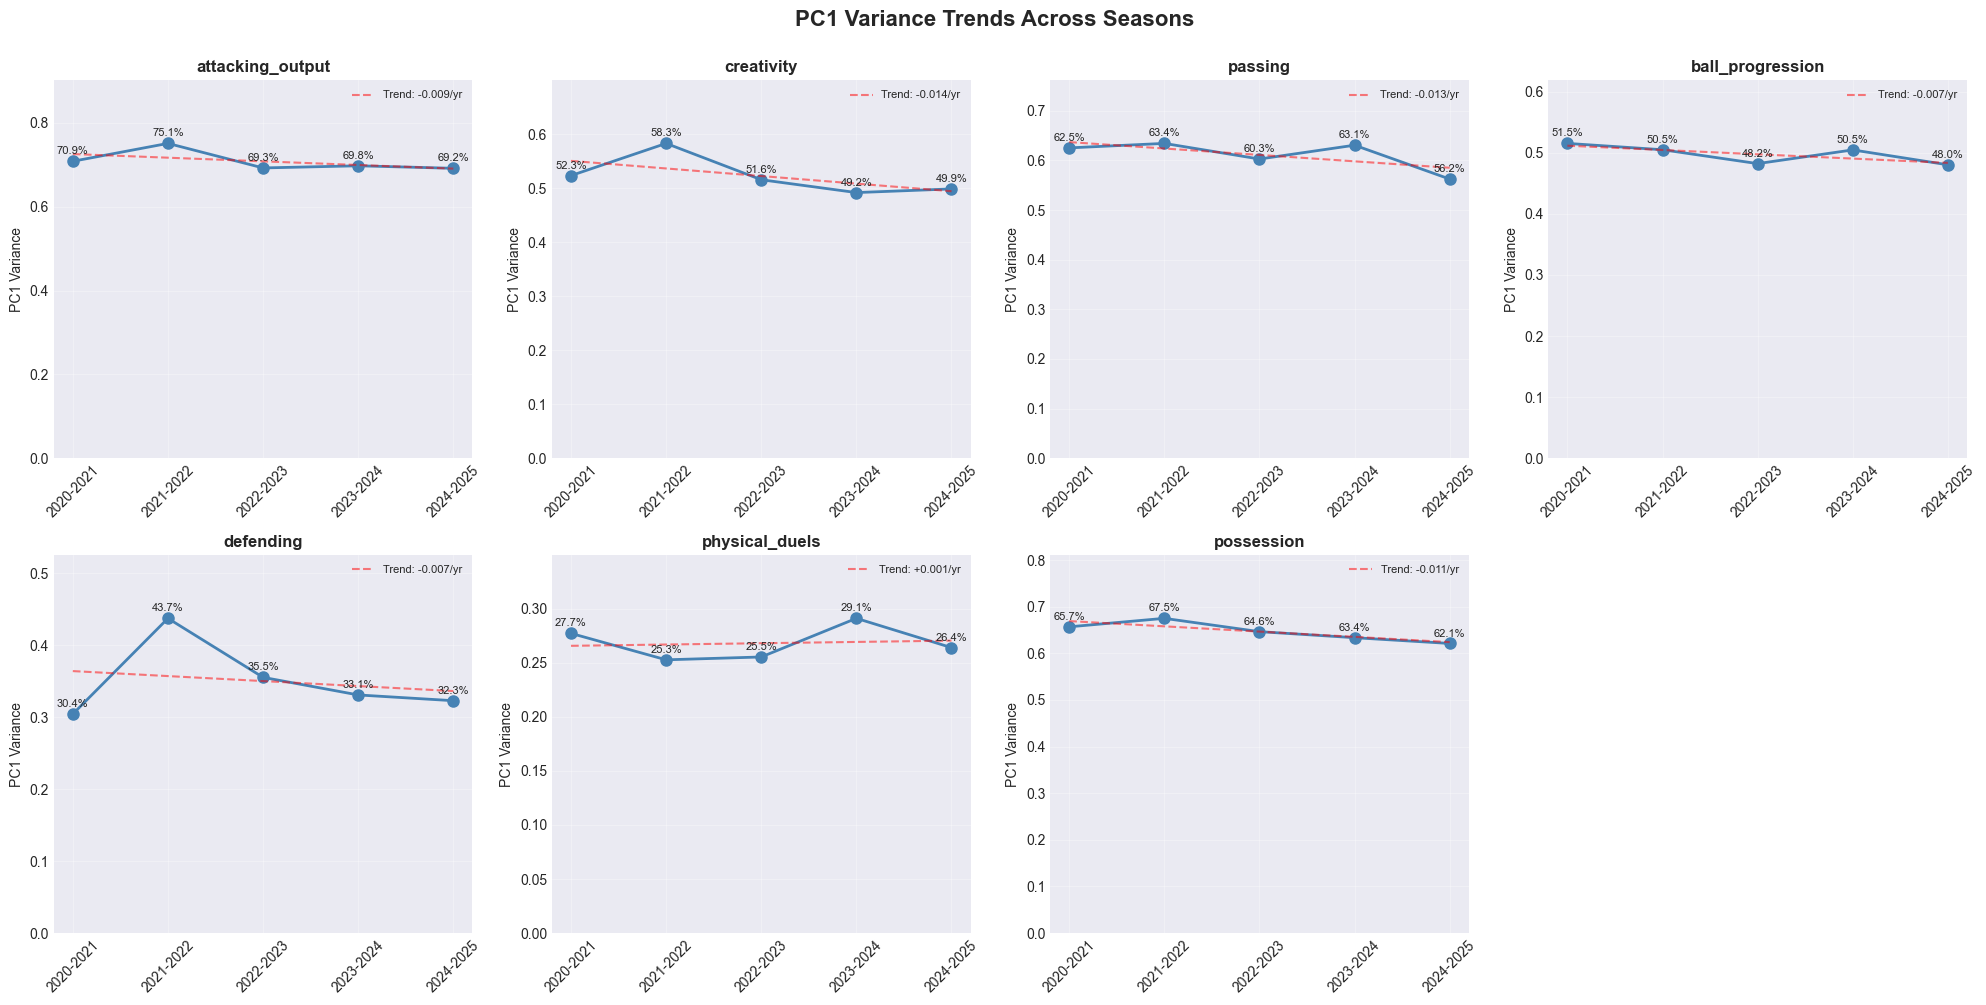


💡 Interpretation:
   - Upward trends: Metrics becoming more correlated over time
   - Downward trends: Metrics becoming more independent
   - Stable trends: Consistent underlying structure


In [91]:
# Line plots showing PC1 variance trends
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, cat_name in enumerate(FULL_CATEGORIES.keys()):
    ax = axes[idx]

    variances = [seasonal_results[cat_name][s]['pc1_variance'] for s in seasons]

    ax.plot(seasons, variances, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax.set_title(cat_name, fontweight='bold', fontsize=12)
    ax.set_ylabel('PC1 Variance', fontsize=10)
    ax.set_ylim([0, max(variances) * 1.2])
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    # Add trend line
    x_numeric = np.arange(len(seasons))
    z = np.polyfit(x_numeric, variances, 1)
    p = np.poly1d(z)
    ax.plot(seasons, p(x_numeric), "--", color='red', alpha=0.5, linewidth=1.5, label=f'Trend: {z[0]:+.3f}/yr')
    ax.legend(fontsize=8)

    # Annotate values
    for i, (s, v) in enumerate(zip(seasons, variances)):
        ax.annotate(f'{v:.1%}', (i, v), textcoords="offset points", xytext=(0,5),
                   ha='center', fontsize=8)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('PC1 Variance Trends Across Seasons', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - Upward trends: Metrics becoming more correlated over time")
print("   - Downward trends: Metrics becoming more independent")
print("   - Stable trends: Consistent underlying structure")

## 6. Load Final League Standings

Get final positions to test if PCA scores predict success.

In [92]:
# Load final league positions for each season
final_positions = {}

for season in seasons:
    query = f"""
    SELECT 
        squad_name,
        (wins * 3 + draws) as points,
        (goals - goals_against) as goal_difference,
        goals,
        ROW_NUMBER() OVER (
            ORDER BY (wins * 3 + draws) DESC, 
                    (goals - goals_against) DESC, 
                    goals DESC
        ) as final_position
    FROM analytics_squads
    WHERE season = '{season}' AND is_current = false
    ORDER BY final_position
    """

    positions_df = conn.execute(query).df()
    final_positions[season] = positions_df.set_index('squad_name')['final_position'].to_dict()

    print(f"📊 {season}:")
    print(f"   Champion: {positions_df.iloc[0]['squad_name']}")
    print(f"   Relegated: {', '.join(positions_df.tail(3)['squad_name'].tolist())}")

print(f"\n✅ Loaded final standings for {len(seasons)} seasons")

📊 2020-2021:
   Champion: Manchester City
   Relegated: Fulham, West Brom, Sheffield Utd
📊 2021-2022:
   Champion: Manchester City
   Relegated: Burnley, Watford, Norwich City
📊 2022-2023:
   Champion: Manchester City
   Relegated: Leicester City, Leeds United, Southampton
📊 2023-2024:
   Champion: Manchester City
   Relegated: Luton Town, Burnley, Sheffield Utd
📊 2024-2025:
   Champion: Liverpool
   Relegated: Leicester City, Ipswich Town, Southampton

✅ Loaded final standings for 5 seasons


## 7. Correlation with League Position

**Test:** Do PCA scores predict final league position?

**Comparison:** PCA-weighted vs equal-weight composite scores

In [93]:
# Calculate correlations for all categories × seasons
correlation_results = []

print("="*80)
print("CORRELATION ANALYSIS: PCA SCORE vs LEAGUE POSITION")
print("="*80)

for cat_name in FULL_CATEGORIES.keys():
    print(f"\n🎯 {cat_name}")

    for season in seasons:
        # Get PCA scores
        pca_scores = seasonal_results[cat_name][season]['scores']
        squad_names = seasonal_results[cat_name][season]['squad_names']

        # Get equal-weight scores
        df_season = season_data[season]
        cat_df, metrics, _ = prepare_category_data(df_season, cat_name, NEGATIVE_METRICS)

        # Standardize and average for equal-weight
        from sklearn.preprocessing import StandardScaler
        scaler_eq = StandardScaler()
        X_equal = cat_df[metrics].values
        X_equal_scaled = scaler_eq.fit_transform(X_equal)
        equal_scores = X_equal_scaled.mean(axis=1)

        # Get final positions
        positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

        # Remove any missing positions
        valid_idx = ~np.isnan(positions)
        pca_scores_valid = pca_scores[valid_idx]
        equal_scores_valid = equal_scores[valid_idx]
        positions_valid = np.array(positions)[valid_idx]

        if len(positions_valid) < 5:  # Skip if too few
            continue

        # Calculate Spearman correlations (position is rank data)
        pca_corr, pca_p = spearmanr(pca_scores_valid, positions_valid)
        equal_corr, equal_p = spearmanr(equal_scores_valid, positions_valid)

        # Note: Negative correlation is good (higher score = lower position number = better)
        pca_corr = -pca_corr  # Flip sign for interpretation
        equal_corr = -equal_corr

        correlation_results.append({
            'Category': cat_name,
            'Season': season,
            'PCA Correlation': pca_corr,
            'Equal-Weight Correlation': equal_corr,
            'PCA Advantage': pca_corr - equal_corr,
            'PCA p-value': pca_p,
            'Equal p-value': equal_p
        })

        winner = 'PCA' if pca_corr > equal_corr else 'Equal'
        print(f"   {season}: PCA={pca_corr:+.3f}, Equal={equal_corr:+.3f}, Winner={winner}")

df_corr = pd.DataFrame(correlation_results)

print("\n" + "="*80)
print("✅ Correlation analysis complete")
print("="*80)

CORRELATION ANALYSIS: PCA SCORE vs LEAGUE POSITION

🎯 attacking_output
   2020-2021: PCA=+0.934, Equal=+0.952, Winner=Equal
   2021-2022: PCA=+0.862, Equal=+0.865, Winner=Equal
   2022-2023: PCA=+0.798, Equal=+0.829, Winner=Equal
   2023-2024: PCA=+0.899, Equal=+0.883, Winner=PCA
   2024-2025: PCA=+0.863, Equal=+0.839, Winner=PCA

🎯 creativity
   2020-2021: PCA=+0.850, Equal=+0.899, Winner=Equal
   2021-2022: PCA=+0.857, Equal=+0.805, Winner=PCA
   2022-2023: PCA=+0.761, Equal=+0.788, Winner=Equal
   2023-2024: PCA=+0.887, Equal=+0.889, Winner=Equal
   2024-2025: PCA=+0.865, Equal=+0.850, Winner=PCA

🎯 passing
   2020-2021: PCA=+0.783, Equal=+0.675, Winner=PCA
   2021-2022: PCA=+0.835, Equal=+0.764, Winner=PCA
   2022-2023: PCA=+0.746, Equal=+0.725, Winner=PCA
   2023-2024: PCA=+0.750, Equal=+0.716, Winner=PCA
   2024-2025: PCA=+0.444, Equal=+0.435, Winner=PCA

🎯 ball_progression
   2020-2021: PCA=+0.641, Equal=+0.740, Winner=Equal
   2021-2022: PCA=+0.911, Equal=+0.866, Winner=PCA
   

## 8. Correlation Summary by Category

In [94]:
# Aggregate correlation results by category
summary_corr = df_corr.groupby('Category').agg({
    'PCA Correlation': 'mean',
    'Equal-Weight Correlation': 'mean',
    'PCA Advantage': 'mean'
}).round(3)

summary_corr['Winner'] = summary_corr.apply(
    lambda row: '🏆 PCA' if row['PCA Advantage'] > 0 else '⚖️ Equal', axis=1
)

display(summary_corr.style.background_gradient(cmap='RdYlGn', subset=['PCA Advantage']))

print("\n💡 Interpretation:")
print("   - Positive correlation: Higher score → better league position")
print("   - PCA Advantage > 0: PCA weighting outperforms equal weighting")
print("   - Statistically, correlation > 0.5 is moderate, > 0.7 is strong")

,PCA Correlation,Equal-Weight Correlation,PCA Advantage,Winner
Category,,,,
attacking_output,0.871000,0.873000,-0.002000,⚖️ Equal
ball_progression,0.732000,0.750000,-0.018000,⚖️ Equal
creativity,0.844000,0.846000,-0.002000,⚖️ Equal
defending,-0.111000,0.094000,-0.205000,⚖️ Equal
passing,0.712000,0.663000,0.049000,🏆 PCA
physical_duels,0.457000,0.513000,-0.056000,⚖️ Equal
possession,0.692000,0.457000,0.235000,🏆 PCA



💡 Interpretation:
   - Positive correlation: Higher score → better league position
   - PCA Advantage > 0: PCA weighting outperforms equal weighting
   - Statistically, correlation > 0.5 is moderate, > 0.7 is strong


In [95]:
# Show full correlation table
display(df_corr.style.background_gradient(cmap='RdYlGn', subset=['PCA Advantage']))

,Category,Season,PCA Correlation,Equal-Weight Correlation,PCA Advantage,PCA p-value,Equal p-value
0,attacking_output,2020-2021,0.933835,0.951880,-0.018045,0.000000,0.000000
1,attacking_output,2021-2022,0.861654,0.864662,-0.003008,0.000001,0.000001
2,attacking_output,2022-2023,0.798496,0.828571,-0.030075,0.000024,0.000006
3,attacking_output,2023-2024,0.899248,0.882707,0.016541,0.000000,0.000000
4,attacking_output,2024-2025,0.863158,0.839098,0.024060,0.000001,0.000004
5,creativity,2020-2021,0.849624,0.899248,-0.049624,0.000002,0.000000
6,creativity,2021-2022,0.857143,0.804511,0.052632,0.000001,0.000019
7,creativity,2022-2023,0.760902,0.787970,-0.027068,0.000098,0.000037
8,creativity,2023-2024,0.887218,0.888722,-0.001504,0.000000,0.000000
9,creativity,2024-2025,0.864662,0.849624,0.015038,0.000001,0.000002


## 9. Scatter Plots: PCA Score vs League Position

### 9.1 attacking_output

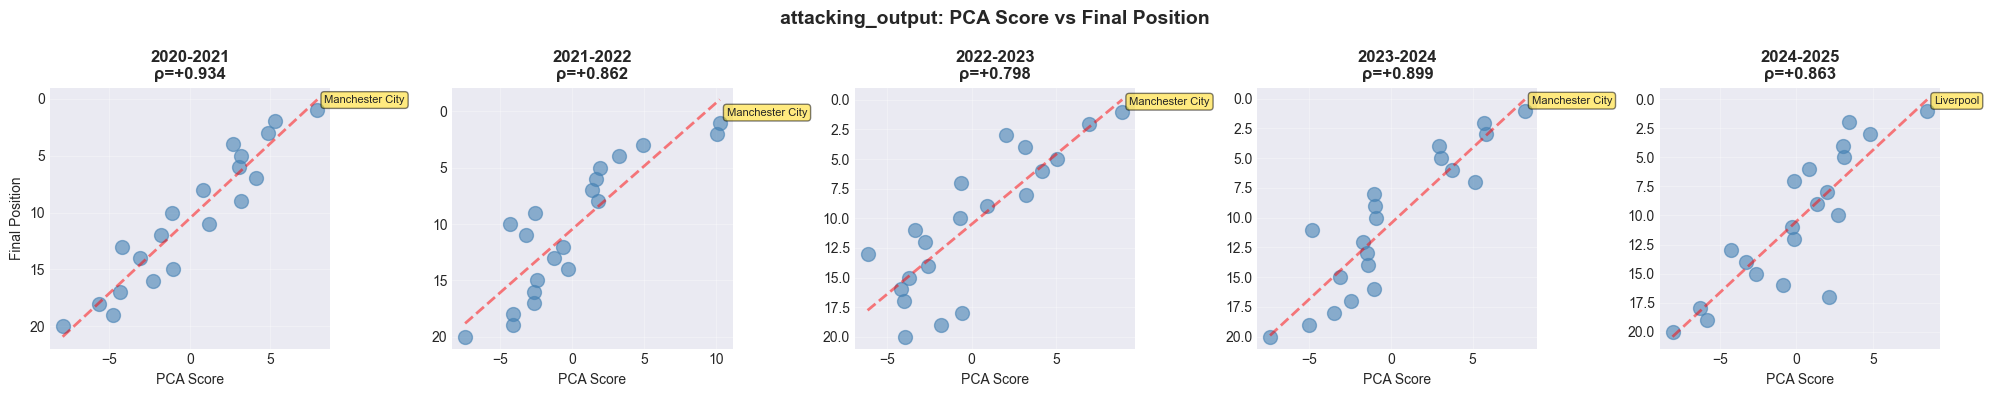


💡 attacking_output average correlation: +0.871


In [96]:
# Scatter plots for attacking_output across seasons
cat_name = 'attacking_output'

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Get data
    pca_scores = seasonal_results[cat_name][season]['scores']
    squad_names = seasonal_results[cat_name][season]['squad_names']
    positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

    # Remove missing
    valid_idx = ~np.isnan(positions)
    pca_scores_valid = pca_scores[valid_idx]
    positions_valid = np.array(positions)[valid_idx]
    squads_valid = np.array(squad_names)[valid_idx]

    # Plot
    ax.scatter(pca_scores_valid, positions_valid, alpha=0.6, s=100, color='steelblue')

    # Get correlation for this season
    season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
    if len(season_corr) > 0:
        corr_val = season_corr.iloc[0]['PCA Correlation']
        ax.set_title(f"{season}\nρ={corr_val:+.3f}", fontweight='bold')
    else:
        ax.set_title(season, fontweight='bold')

    ax.set_xlabel('PCA Score', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Final Position', fontsize=10)
    ax.invert_yaxis()  # Lower position = better
    ax.grid(True, alpha=0.3)

    # Add trend line
    if len(pca_scores_valid) > 2:
        z = np.polyfit(pca_scores_valid, positions_valid, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pca_scores_valid.min(), pca_scores_valid.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

    # Label champions and relegated
    if len(positions_valid) > 0:
        champ_idx = np.argmin(positions_valid)
        ax.annotate(squads_valid[champ_idx],
                   (pca_scores_valid[champ_idx], positions_valid[champ_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))

fig.suptitle(f'{cat_name}: PCA Score vs Final Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 {cat_name} average correlation: {df_corr[df_corr['Category']==cat_name]['PCA Correlation'].mean():+.3f}")

### 9.2 creativity

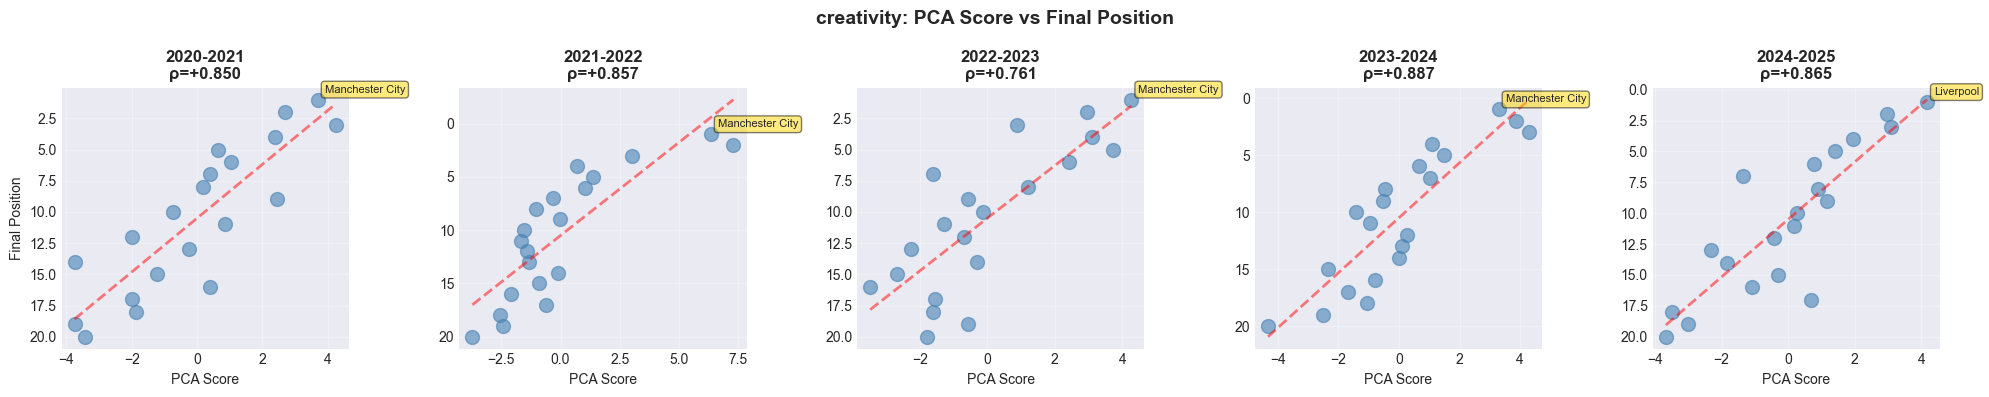


💡 creativity average correlation: +0.844


In [97]:
# Scatter plots for creativity across seasons
cat_name = 'creativity'

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Get data
    pca_scores = seasonal_results[cat_name][season]['scores']
    squad_names = seasonal_results[cat_name][season]['squad_names']
    positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

    # Remove missing
    valid_idx = ~np.isnan(positions)
    pca_scores_valid = pca_scores[valid_idx]
    positions_valid = np.array(positions)[valid_idx]
    squads_valid = np.array(squad_names)[valid_idx]

    # Plot
    ax.scatter(pca_scores_valid, positions_valid, alpha=0.6, s=100, color='steelblue')

    # Get correlation for this season
    season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
    if len(season_corr) > 0:
        corr_val = season_corr.iloc[0]['PCA Correlation']
        ax.set_title(f"{season}\nρ={corr_val:+.3f}", fontweight='bold')
    else:
        ax.set_title(season, fontweight='bold')

    ax.set_xlabel('PCA Score', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Final Position', fontsize=10)
    ax.invert_yaxis()  # Lower position = better
    ax.grid(True, alpha=0.3)

    # Add trend line
    if len(pca_scores_valid) > 2:
        z = np.polyfit(pca_scores_valid, positions_valid, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pca_scores_valid.min(), pca_scores_valid.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

    # Label champions and relegated
    if len(positions_valid) > 0:
        champ_idx = np.argmin(positions_valid)
        ax.annotate(squads_valid[champ_idx],
                   (pca_scores_valid[champ_idx], positions_valid[champ_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))

fig.suptitle(f'{cat_name}: PCA Score vs Final Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 {cat_name} average correlation: {df_corr[df_corr['Category']==cat_name]['PCA Correlation'].mean():+.3f}")

### 9.3 passing

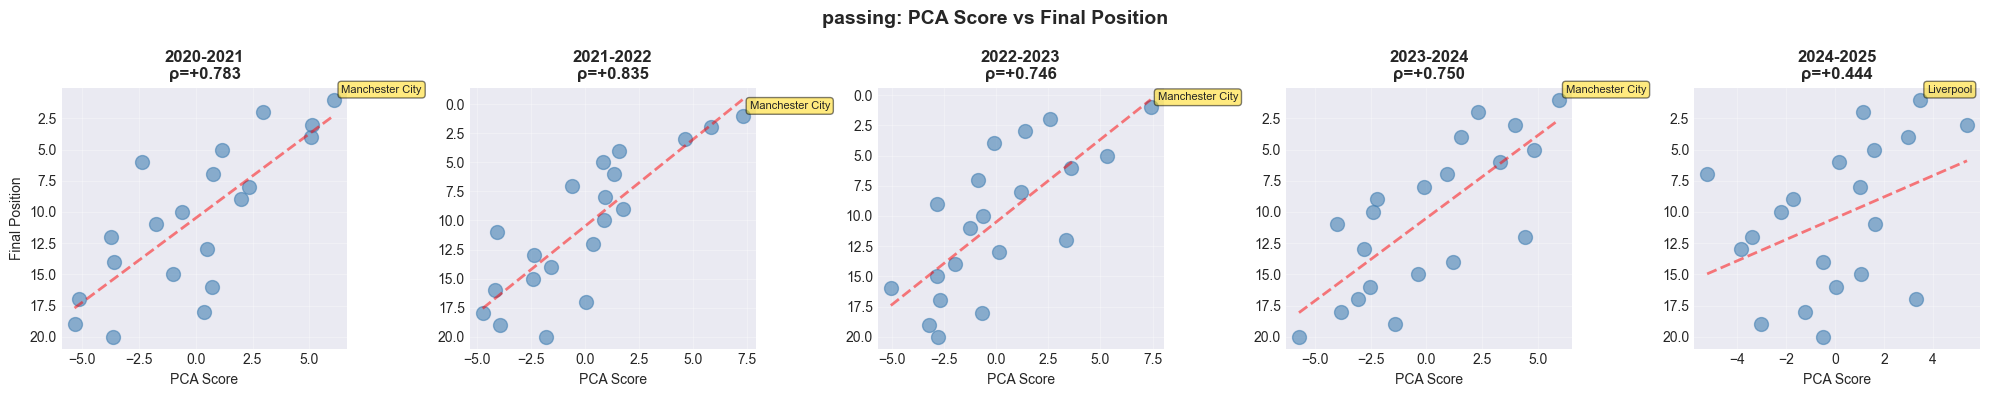


💡 passing average correlation: +0.712


In [98]:
# Scatter plots for passing across seasons
cat_name = 'passing'

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Get data
    pca_scores = seasonal_results[cat_name][season]['scores']
    squad_names = seasonal_results[cat_name][season]['squad_names']
    positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

    # Remove missing
    valid_idx = ~np.isnan(positions)
    pca_scores_valid = pca_scores[valid_idx]
    positions_valid = np.array(positions)[valid_idx]
    squads_valid = np.array(squad_names)[valid_idx]

    # Plot
    ax.scatter(pca_scores_valid, positions_valid, alpha=0.6, s=100, color='steelblue')

    # Get correlation for this season
    season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
    if len(season_corr) > 0:
        corr_val = season_corr.iloc[0]['PCA Correlation']
        ax.set_title(f"{season}\nρ={corr_val:+.3f}", fontweight='bold')
    else:
        ax.set_title(season, fontweight='bold')

    ax.set_xlabel('PCA Score', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Final Position', fontsize=10)
    ax.invert_yaxis()  # Lower position = better
    ax.grid(True, alpha=0.3)

    # Add trend line
    if len(pca_scores_valid) > 2:
        z = np.polyfit(pca_scores_valid, positions_valid, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pca_scores_valid.min(), pca_scores_valid.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

    # Label champions and relegated
    if len(positions_valid) > 0:
        champ_idx = np.argmin(positions_valid)
        ax.annotate(squads_valid[champ_idx],
                   (pca_scores_valid[champ_idx], positions_valid[champ_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))

fig.suptitle(f'{cat_name}: PCA Score vs Final Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 {cat_name} average correlation: {df_corr[df_corr['Category']==cat_name]['PCA Correlation'].mean():+.3f}")

### 9.4 ball_progression

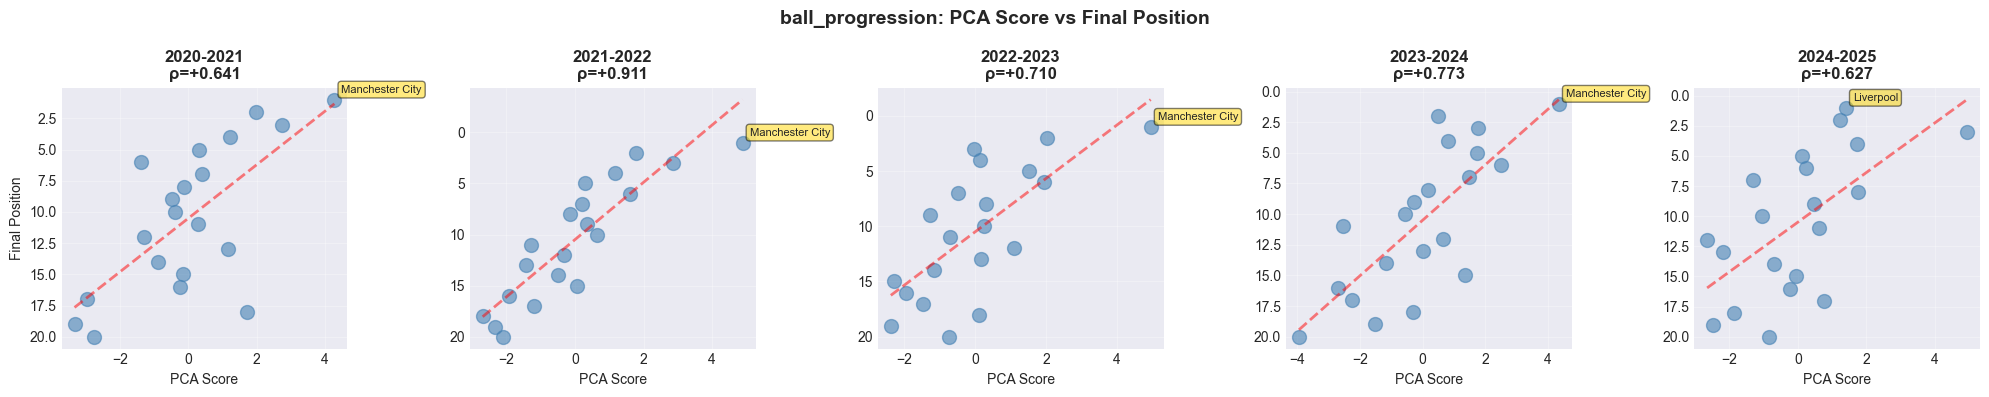


💡 ball_progression average correlation: +0.732


In [99]:
# Scatter plots for ball_progression across seasons
cat_name = 'ball_progression'

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Get data
    pca_scores = seasonal_results[cat_name][season]['scores']
    squad_names = seasonal_results[cat_name][season]['squad_names']
    positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

    # Remove missing
    valid_idx = ~np.isnan(positions)
    pca_scores_valid = pca_scores[valid_idx]
    positions_valid = np.array(positions)[valid_idx]
    squads_valid = np.array(squad_names)[valid_idx]

    # Plot
    ax.scatter(pca_scores_valid, positions_valid, alpha=0.6, s=100, color='steelblue')

    # Get correlation for this season
    season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
    if len(season_corr) > 0:
        corr_val = season_corr.iloc[0]['PCA Correlation']
        ax.set_title(f"{season}\nρ={corr_val:+.3f}", fontweight='bold')
    else:
        ax.set_title(season, fontweight='bold')

    ax.set_xlabel('PCA Score', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Final Position', fontsize=10)
    ax.invert_yaxis()  # Lower position = better
    ax.grid(True, alpha=0.3)

    # Add trend line
    if len(pca_scores_valid) > 2:
        z = np.polyfit(pca_scores_valid, positions_valid, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pca_scores_valid.min(), pca_scores_valid.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

    # Label champions and relegated
    if len(positions_valid) > 0:
        champ_idx = np.argmin(positions_valid)
        ax.annotate(squads_valid[champ_idx],
                   (pca_scores_valid[champ_idx], positions_valid[champ_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))

fig.suptitle(f'{cat_name}: PCA Score vs Final Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 {cat_name} average correlation: {df_corr[df_corr['Category']==cat_name]['PCA Correlation'].mean():+.3f}")

### 9.5 defending

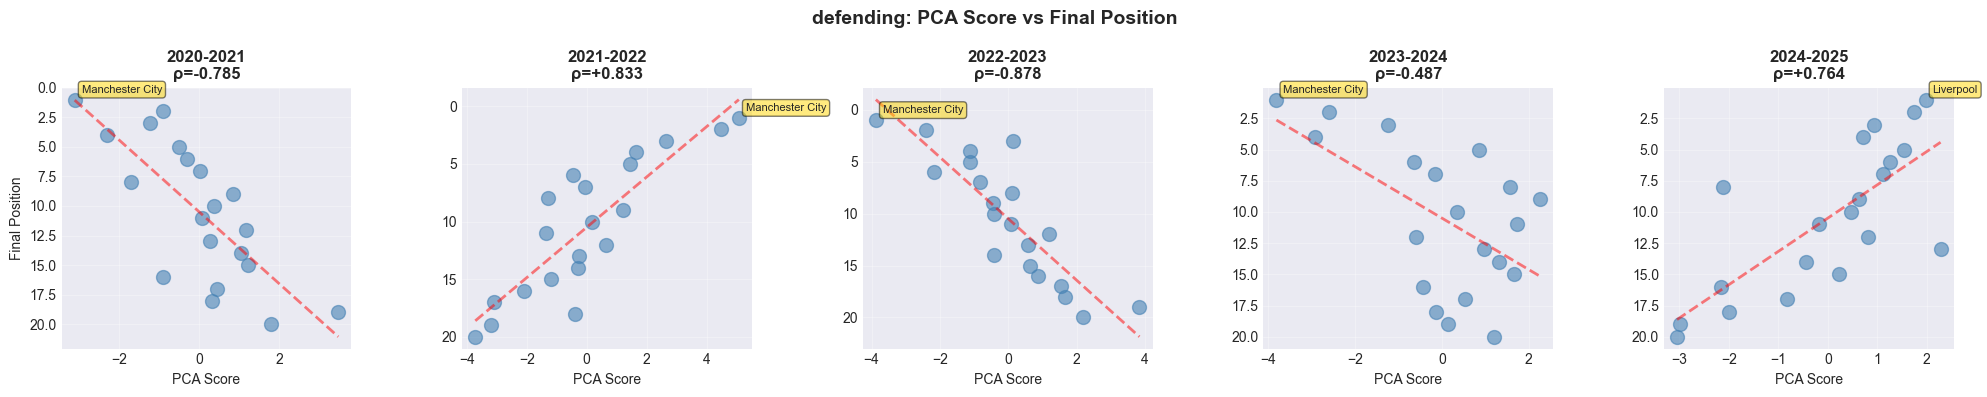


💡 defending average correlation: -0.111


In [100]:
# Scatter plots for defending across seasons
cat_name = 'defending'

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Get data
    pca_scores = seasonal_results[cat_name][season]['scores']
    squad_names = seasonal_results[cat_name][season]['squad_names']
    positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

    # Remove missing
    valid_idx = ~np.isnan(positions)
    pca_scores_valid = pca_scores[valid_idx]
    positions_valid = np.array(positions)[valid_idx]
    squads_valid = np.array(squad_names)[valid_idx]

    # Plot
    ax.scatter(pca_scores_valid, positions_valid, alpha=0.6, s=100, color='steelblue')

    # Get correlation for this season
    season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
    if len(season_corr) > 0:
        corr_val = season_corr.iloc[0]['PCA Correlation']
        ax.set_title(f"{season}\nρ={corr_val:+.3f}", fontweight='bold')
    else:
        ax.set_title(season, fontweight='bold')

    ax.set_xlabel('PCA Score', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Final Position', fontsize=10)
    ax.invert_yaxis()  # Lower position = better
    ax.grid(True, alpha=0.3)

    # Add trend line
    if len(pca_scores_valid) > 2:
        z = np.polyfit(pca_scores_valid, positions_valid, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pca_scores_valid.min(), pca_scores_valid.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

    # Label champions and relegated
    if len(positions_valid) > 0:
        champ_idx = np.argmin(positions_valid)
        ax.annotate(squads_valid[champ_idx],
                   (pca_scores_valid[champ_idx], positions_valid[champ_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))

fig.suptitle(f'{cat_name}: PCA Score vs Final Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 {cat_name} average correlation: {df_corr[df_corr['Category']==cat_name]['PCA Correlation'].mean():+.3f}")

### 9.6 physical_duels

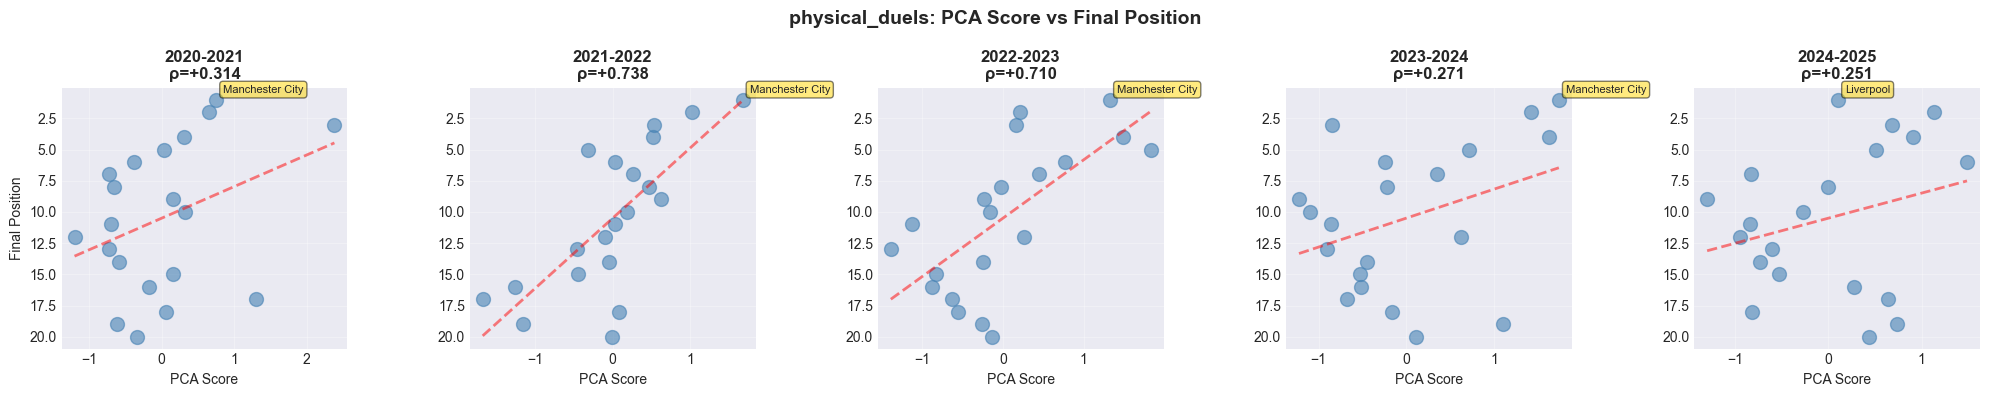


💡 physical_duels average correlation: +0.457


In [101]:
# Scatter plots for physical_duels across seasons
cat_name = 'physical_duels'

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Get data
    pca_scores = seasonal_results[cat_name][season]['scores']
    squad_names = seasonal_results[cat_name][season]['squad_names']
    positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

    # Remove missing
    valid_idx = ~np.isnan(positions)
    pca_scores_valid = pca_scores[valid_idx]
    positions_valid = np.array(positions)[valid_idx]
    squads_valid = np.array(squad_names)[valid_idx]

    # Plot
    ax.scatter(pca_scores_valid, positions_valid, alpha=0.6, s=100, color='steelblue')

    # Get correlation for this season
    season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
    if len(season_corr) > 0:
        corr_val = season_corr.iloc[0]['PCA Correlation']
        ax.set_title(f"{season}\nρ={corr_val:+.3f}", fontweight='bold')
    else:
        ax.set_title(season, fontweight='bold')

    ax.set_xlabel('PCA Score', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Final Position', fontsize=10)
    ax.invert_yaxis()  # Lower position = better
    ax.grid(True, alpha=0.3)

    # Add trend line
    if len(pca_scores_valid) > 2:
        z = np.polyfit(pca_scores_valid, positions_valid, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pca_scores_valid.min(), pca_scores_valid.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

    # Label champions and relegated
    if len(positions_valid) > 0:
        champ_idx = np.argmin(positions_valid)
        ax.annotate(squads_valid[champ_idx],
                   (pca_scores_valid[champ_idx], positions_valid[champ_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))

fig.suptitle(f'{cat_name}: PCA Score vs Final Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 {cat_name} average correlation: {df_corr[df_corr['Category']==cat_name]['PCA Correlation'].mean():+.3f}")

### 9.7 possession

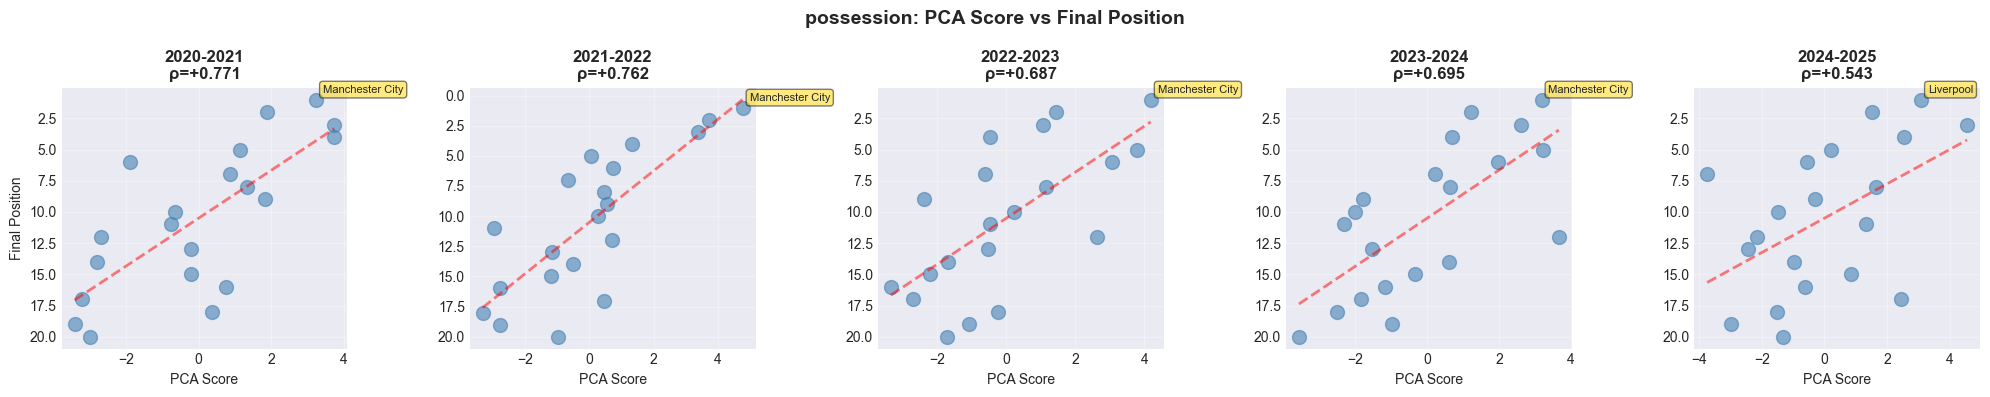


💡 possession average correlation: +0.692


In [102]:
# Scatter plots for possession across seasons
cat_name = 'possession'

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, season in enumerate(seasons):
    ax = axes[idx]

    # Get data
    pca_scores = seasonal_results[cat_name][season]['scores']
    squad_names = seasonal_results[cat_name][season]['squad_names']
    positions = [final_positions[season].get(squad, np.nan) for squad in squad_names]

    # Remove missing
    valid_idx = ~np.isnan(positions)
    pca_scores_valid = pca_scores[valid_idx]
    positions_valid = np.array(positions)[valid_idx]
    squads_valid = np.array(squad_names)[valid_idx]

    # Plot
    ax.scatter(pca_scores_valid, positions_valid, alpha=0.6, s=100, color='steelblue')

    # Get correlation for this season
    season_corr = df_corr[(df_corr['Category'] == cat_name) & (df_corr['Season'] == season)]
    if len(season_corr) > 0:
        corr_val = season_corr.iloc[0]['PCA Correlation']
        ax.set_title(f"{season}\nρ={corr_val:+.3f}", fontweight='bold')
    else:
        ax.set_title(season, fontweight='bold')

    ax.set_xlabel('PCA Score', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Final Position', fontsize=10)
    ax.invert_yaxis()  # Lower position = better
    ax.grid(True, alpha=0.3)

    # Add trend line
    if len(pca_scores_valid) > 2:
        z = np.polyfit(pca_scores_valid, positions_valid, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pca_scores_valid.min(), pca_scores_valid.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

    # Label champions and relegated
    if len(positions_valid) > 0:
        champ_idx = np.argmin(positions_valid)
        ax.annotate(squads_valid[champ_idx],
                   (pca_scores_valid[champ_idx], positions_valid[champ_idx]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.5))

fig.suptitle(f'{cat_name}: PCA Score vs Final Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 {cat_name} average correlation: {df_corr[df_corr['Category']==cat_name]['PCA Correlation'].mean():+.3f}")

## 10. Final Summary & Recommendations

In [103]:
print("="*80)
print("FINAL ASSESSMENT - INDIVIDUAL SEASON COMPARISON")
print("="*80)

print("\n📊 STABILITY RESULTS:")
for cat_name in FULL_CATEGORIES.keys():
    stability = seasonal_results[cat_name]['stability']
    status = '✅ STABLE' if stability['is_stable'] else '⚠️  UNSTABLE'
    print(f"   {cat_name:20s}: {stability['stability_score']:5.1%}  {status}")

print("\n📊 PREDICTIVE POWER (Average PCA Correlation):")
avg_corrs = df_corr.groupby('Category')['PCA Correlation'].mean().sort_values(ascending=False)
for cat_name, corr in avg_corrs.items():
    strength = '🔥 Strong' if abs(corr) > 0.7 else '✓ Moderate' if abs(corr) > 0.5 else '⚠️  Weak'
    print(f"   {cat_name:20s}: {corr:+.3f}  {strength}")

print("\n📊 PCA vs EQUAL-WEIGHT:")
for cat_name in FULL_CATEGORIES.keys():
    avg_adv = df_corr[df_corr['Category'] == cat_name]['PCA Advantage'].mean()
    winner = '🏆 PCA' if avg_adv > 0 else '⚖️ Equal'
    print(f"   {cat_name:20s}: {avg_adv:+.3f}  {winner}")

print("\n💡 RECOMMENDATIONS:")

# Stable + good correlation + PCA advantage
excellent = [cat for cat in FULL_CATEGORIES.keys()
            if seasonal_results[cat]['stability']['is_stable']
            and df_corr[df_corr['Category']==cat]['PCA Correlation'].mean() > 0.6
            and df_corr[df_corr['Category']==cat]['PCA Advantage'].mean() > 0]

if excellent:
    print(f"\n✅ USE 10-YEAR BASELINE for: {', '.join(excellent)}")
    print("   → Stable loadings + strong prediction + PCA outperforms equal-weight")

# Unstable but good correlation
dynamic = [cat for cat in FULL_CATEGORIES.keys()
          if not seasonal_results[cat]['stability']['is_stable']
          and df_corr[df_corr['Category']==cat]['PCA Correlation'].mean() > 0.5]

if dynamic:
    print(f"\n⚠️  USE DYNAMIC/ROLLING WINDOW for: {', '.join(dynamic)}")
    print("   → Loadings shift but still predictive - need season-specific models")

# Poor predictors
poor = [cat for cat in FULL_CATEGORIES.keys()
       if df_corr[df_corr['Category']==cat]['PCA Correlation'].mean() < 0.5]

if poor:
    print(f"\n❌ RECONSIDER APPROACH for: {', '.join(poor)}")
    print("   → Weak correlation with league position")

print("\n" + "="*80)
print("✅ COMPREHENSIVE SEASONAL COMPARISON COMPLETE")
print("="*80)

FINAL ASSESSMENT - INDIVIDUAL SEASON COMPARISON

📊 STABILITY RESULTS:
   attacking_output    : 80.0%  ✅ STABLE
   creativity          : 80.0%  ✅ STABLE
   passing             : 80.0%  ✅ STABLE
   ball_progression    : 100.0%  ✅ STABLE
   defending           : 40.0%  ⚠️  UNSTABLE
   physical_duels      : 40.0%  ⚠️  UNSTABLE
   possession          : 80.0%  ✅ STABLE

📊 PREDICTIVE POWER (Average PCA Correlation):
   attacking_output    : +0.871  🔥 Strong
   creativity          : +0.844  🔥 Strong
   ball_progression    : +0.732  🔥 Strong
   passing             : +0.712  🔥 Strong
   possession          : +0.692  ✓ Moderate
   physical_duels      : +0.457  ⚠️  Weak
   defending           : -0.111  ⚠️  Weak

📊 PCA vs EQUAL-WEIGHT:
   attacking_output    : -0.002  ⚖️ Equal
   creativity          : -0.002  ⚖️ Equal
   passing             : +0.049  🏆 PCA
   ball_progression    : -0.018  ⚖️ Equal
   defending           : -0.205  ⚖️ Equal
   physical_duels      : -0.056  ⚖️ Equal
   possession     